# Finetuning Plbart

## Downloading libraries

In [1]:
!pip install -q transformers[sentencepiece] datasets sacrebleu evaluate accelerate wget

## Importing libraries

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments

from datasets import load_dataset, Dataset, DatasetDict
import json
import numpy as np
from tqdm.auto import tqdm
import tarfile
import os
import shutil
import wget

2024-06-16 19:00:45.078309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 19:00:45.078403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 19:00:45.207978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---------------------------------------------------------------------------
## Data Loading

In [3]:
data = load_dataset('/kaggle/input/dataset/')

train_testvalid = data['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['code_source', 'test_case'],
        num_rows: 816
    })
    test: Dataset({
        features: ['code_source', 'test_case'],
        num_rows: 102
    })
    valid: Dataset({
        features: ['code_source', 'test_case'],
        num_rows: 102
    })
})

## Loading the Tokenizer

In [5]:
model_checkpoint = "Marie-Laure/plbart-assert"


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


tokenizer_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/986k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

In [7]:
def preprocess_data(data):
    inputs = data["code_source"]
    targets = data["test_case"]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=context_length, truncation=True
    )
    return model_inputs

In [8]:
context_length = 1024

In [9]:
tokenized_dataset = dataset.map(
    preprocess_data,
    remove_columns=dataset["train"].column_names,
    batched=True
)

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 816
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 102
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 102
    })
})

## Loading the model

In [33]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint) 

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [34]:
def get_number_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [35]:

print("Number of parameters : ", get_number_parameters(model))

Number of parameters :  406025216


In [36]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

## Define training arguments

In [37]:
!pip install wandb

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [38]:
import os
os.environ["WANDB_DISABLED"] = "True"

In [39]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(

    f"PLBART_method_2_test_JAVA",
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    eval_strategy="no",
    save_strategy="steps",
    save_steps=3000,
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.05,
    save_total_limit=3,
    num_train_epochs=12,
    predict_with_generate=True,
    fp16=True
    
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [40]:
import os

output_dir = "Finetuned_PLBART_Java_Unit_Test_Generator"
os.makedirs(output_dir, exist_ok=True)

## Fine Tuning :

In [41]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
                    model,
                    args=args,
                    train_dataset=tokenized_dataset["train"],
                    eval_dataset=tokenized_dataset["valid"],
                    data_collator=data_collator,
                    tokenizer=tokenizer
                )

In [42]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
10,2.089900
20,1.273600
30,1.182900
40,1.075700
50,1.057700
60,0.968700
70,0.919700
80,0.943600
90,0.862300
100,0.961300


TrainOutput(global_step=2328, training_loss=0.3199285740653674, metrics={'train_runtime': 6764.7107, 'train_samples_per_second': 2.753, 'train_steps_per_second': 0.344, 'total_flos': 1.637027430334464e+16, 'train_loss': 0.3199285740653674, 'epoch': 12.0})

In [ ]:
trainer.state.log_history

In [43]:
train_loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])

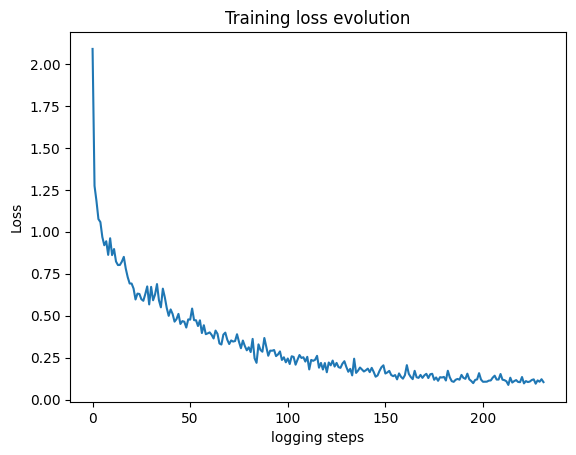

In [44]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel('logging steps')
plt.ylabel('Loss')
plt.title('Training loss evolution')
plt.show()

## Evaluating The Model :

In [15]:
import evaluate
import torch
import statistics

metric = evaluate.load("sacrebleu")

def evaluate(eval_set, model, tokenizer, max_tokens, debug=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    scores = []

    model.eval()
    for data in tqdm(eval_set):
        input_ids = torch.tensor([data["input_ids"]]).to(device)
        attention_mask = torch.tensor([data["attention_mask"]]).to(device)
        inputs = {"input_ids": input_ids, "attention_mask": attention_mask}

        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=max_tokens)

        prediction = tokenizer.decode(output[0], skip_special_tokens=True)


        reference = tokenizer.decode(data['labels'], skip_special_tokens=True)
        if debug:
            print("\n-------------ref----------------\n")
            print(reference)
            print("\n-------------prediction----------------\n")
            print(prediction)
        scores.append(metric.compute(predictions=[prediction], references=[[reference]])['score'])

    mean_bleu_score = statistics.mean(scores)

    return mean_bleu_score

In [17]:
bleu_score = evaluate(tokenized_dataset['test'], trainer.model, tokenizer, 512)

  0%|          | 0/102 [00:00<?, ?it/s]

In [18]:
bleu_score

71.8173509497456

## Saving the model :

In [48]:
trainer.save_model()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


In [49]:
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .


Enter your token (input will not be visible):  ·····································
Add token as git credential? (Y/n)  n


Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [50]:
trainer.push_to_hub("ayoub-edh/Finetuned_PLBART_Java_Unit_Test_Generator")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


sentencepiece.bpe.model:   0%|          | 0.00/986k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

events.out.tfevents.1718360354.2e3e6addb290.34.0:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ayoub-edh/PLBART_method_2_test_JAVA/commit/d692a8e379a7f9e037c5cbc383ea95db7d7e19f9', commit_message='ayoub-edh/PLBART_method_2_test_JAVA', commit_description='', oid='d692a8e379a7f9e037c5cbc383ea95db7d7e19f9', pr_url=None, pr_revision=None, pr_num=None)

## Testing the Model Inference

In [3]:
tokenizer = AutoTokenizer.from_pretrained("ayoub-edh/Finetuned_PLBART_Java_Unit_Test_Generator")

tokenizer_config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/986k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained("ayoub-edh/Finetuned_PLBART_Java_Unit_Test_Generator")

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import torch

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [7]:
device

device(type='cuda')

In [8]:

pipe = pipeline("translation", model=model, tokenizer=tokenizer, device=device)

In [16]:
def reformat_java_code(code):
    import re
    code = re.sub(r'\s+', ' ', code)
    code = code.replace('; ', ';\n')
    code = code.replace('{ ', '{\n')
    code = code.replace('} ', '}\n')
    
    indentation_level = 0
    formatted_code = ""
    for line in code.split('\n'):
        if '}' in line:
            indentation_level -= 1
        formatted_code += '    ' * indentation_level + line.strip() + '\n'
        if '{' in line:
            indentation_level += 1
            
    return formatted_code.strip()


In [9]:
code = """
    public class PalindromeChecker {
    public static boolean isPalindrome(String str) {
        int left = 0;
        int right = str.length() - 1;

        while (left < right) {
            if (str.charAt(left) != str.charAt(right)) {
                return false;
            }
            left++;
            right--;
        }
        return true;
    }
}
    """

In [12]:
print(reformat_java_code(pipe(code, max_new_tokens=512, num_return_sequences=1, src_lang="java", tgt_lang="java")[0]['translation_text']))

Your input_length: 70 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


org.junit.Test;
import static org.junit.Assert.*;
public class PalindromeCheckerTest {
    @Test public void testIsPalindrome_true() {
        assertTrue(PalindromeChecker.isPalindrome("A man, a plan, a canal: Panama"));
        assertTrue(PalindromeChecker.isPalindrome("Was it a car or a cat I saw?"));
    }
    @Test public void testIsPalindrome_false() {
        assertFalse(PalindromeChecker.isPalindrome("A man, a plan, a canal: Panama"));
        assertFalse(PalindromeChecker.isPalindrome("A car"));
        assertFalse(PalindromeChecker.isPalindrome("Was it a car"));
    }
}


In [13]:
code = """
public class SquareRoot {
    public static double sqrt(double number) {
        if (number < 0) {
            throw new IllegalArgumentException("Cannot compute square root of a negative number");
        }
        return Math.sqrt(number);
    }
}
    """

print(reformat_java_code(pipe(code, max_new_tokens=512, num_return_sequences=1, src_lang="java", tgt_lang="java")[0]['translation_text']))

Your input_length: 46 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


import static org.junit.jupiter.api.Assertions.*;
public class SquareRootTest {
    @Test public void testSqrt() {
        assertEquals(1.0, SquareRoot.sqrt(1), 0.0);
    }
    @Test public void testSqrtWithZero() {
        assertEquals(0.0, SquareRoot.sqrt(0), 0.0);
    }
    @Test public void testSqrtWithNegativeNumber() {
        assertEquals(-5, SquareRoot.sqrt(-5), 0.0);
    }
}


In [14]:
code = """
public class CircleArea {
    public static double area(double radius) {
        if (radius < 0) {
            throw new IllegalArgumentException("Radius cannot be negative");
        }
        return Math.PI * radius * radius;
    }
}
    """

print(reformat_java_code(pipe(code, max_new_tokens=512, num_return_sequences=1, src_lang="java", tgt_lang="java")[0]['translation_text']))

Your input_length: 44 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


import static org.junit.jupiter.api.Assertions.*;
import org.junit.jupiter.api.Test;
public class CircleAreaTest {
    @Test public void testArea() {
        double radius = 2.0;
        double expected = Math.PI * radius * radius;
        double result = CircleArea.area(radius);
        assertEquals(expected, result, 0.0001);
    }
}
